In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('./data/GOOGL.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [3]:
data = df[['Close']]

In [4]:
data.shape

(253, 1)

In [5]:
train = data[:-5]
test = data[-5:]

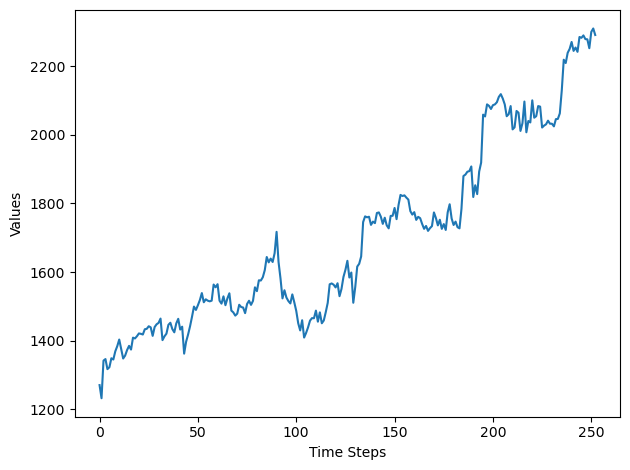

In [7]:
# Check for stationarity
fig,ax = plt.subplots()

plt.plot(data)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Values')
plt.tight_layout()

In [8]:
# Test for stationarity

ADF = adfuller(data)

print(f"ADF statistic: {ADF[0]}")
print(f"p-value: {ADF[1]}")

ADF statistic: 0.1602504866477131
p-value: 0.9699419435913057


#### The ADF statistic is not a high negative and the p value is greater than 0.05, So this data is not stationary. So we perform first order differencing

In [14]:
# First order differencing
diff_data = np.diff(data['Close'],n=1)

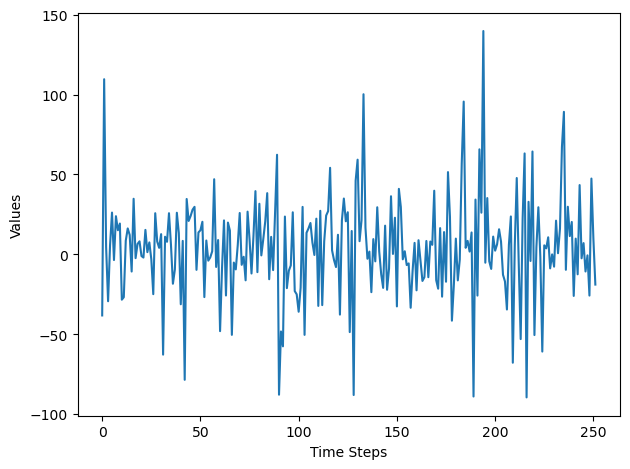

In [16]:
# Plot the first order differenced data

fig,ax = plt.subplots()

plt.plot(diff_data)
ax.set_xlabel('Time Steps')
ax.set_ylabel('Values')
plt.tight_layout()

In [17]:
# Perform AD Fuller test to check for stationarity
ADF = adfuller(diff_data)

print(f"ADF statistic: {ADF[0]}")
print(f"p-value: {ADF[1]}")

ADF statistic: -5.3034397042952275
p-value: 5.386530961454739e-06


#### The adf statistic is negative and p value is less than 0.05, so we can say that the data is stationary now.

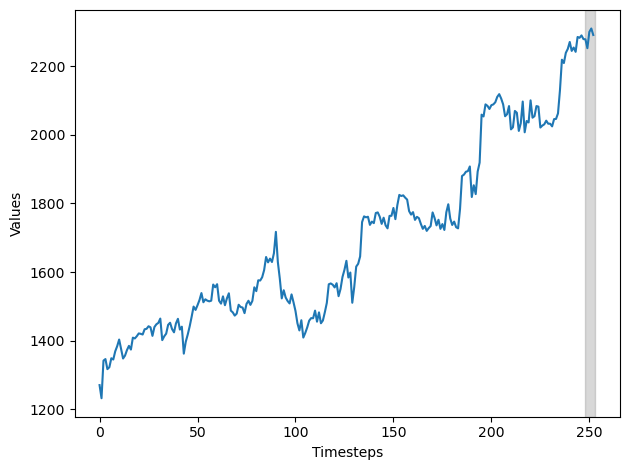

In [20]:
fig, ax = plt.subplots()

ax.plot(df['Close'])
ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')
ax.axvspan(xmin=248,xmax=253,color ='#808080',alpha = 0.3 )
plt.tight_layout()

In [25]:
# Forecasting using different naive forecasting methods

# mean value prediction
mean = np.mean(train['Close'].values)

test.loc[:,'pred_mean'] = mean

test.head()

,Close,pred_mean
248,2278.350098,1689.993184
249,2252.520020,1689.993184
250,2299.929932,1689.993184
251,2309.929932,1689.993184
252,2290.979980,1689.993184


In [26]:
# predicting using the last value of the train dataset

last_value = train['Close'].iloc[-1]

test.loc[:,'pred_last'] = last_value

test.head()

,Close,pred_mean,pred_last
248,2278.350098,1689.993184,2279.01001
249,2252.520020,1689.993184,2279.01001
250,2299.929932,1689.993184,2279.01001
251,2309.929932,1689.993184,2279.01001
252,2290.979980,1689.993184,2279.01001


In [28]:
# drift prediction

deltaX = len(train) - 1
deltaY = last_value - train['Close'][0] # doubt

drift = deltaY / deltaX

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals

test.loc[:, 'pred_drift'] = pred_drift

test.head()

,Close,pred_mean,pred_last,pred_drift
248,2278.350098,1689.993184,2279.01001,1012.231604
249,2252.520020,1689.993184,2279.01001,1016.313183
250,2299.929932,1689.993184,2279.01001,1020.394762
251,2309.929932,1689.993184,2279.01001,1024.476341
252,2290.979980,1689.993184,2279.01001,1028.557920


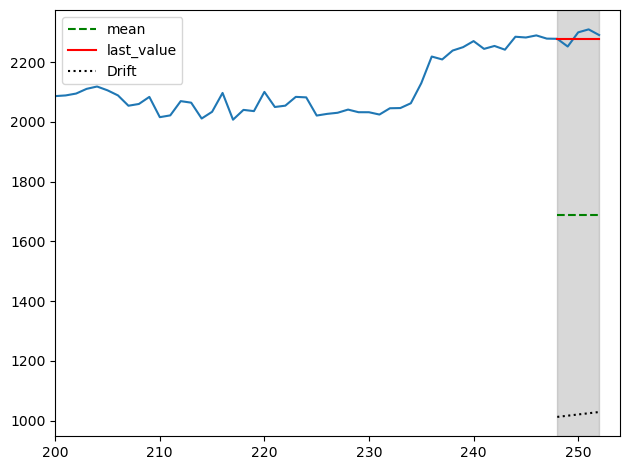

In [39]:
# Plotting the forecasts

fig,ax = plt.subplots()

ax.plot(df['Close'])
ax.plot(test['pred_mean'],'g--',label = 'mean')
ax.plot(test['pred_last'],'r-',label = 'last_value')
ax.plot(test['pred_drift'],'k:',label = 'Drift')
ax.set_xlim(200,254)

ax.axvspan(xmin=248,xmax=252,color ='#808080',alpha = 0.3 )
ax.legend(loc = 2)
plt.tight_layout()

In [40]:
mse_mean = mean_squared_error(test['Close'], test['pred_mean'])
mse_last = mean_squared_error(test['Close'], test['pred_last'])
mse_drift = mean_squared_error(test['Close'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

356025.96701539395 447.82398976418415 1602914.8052603137


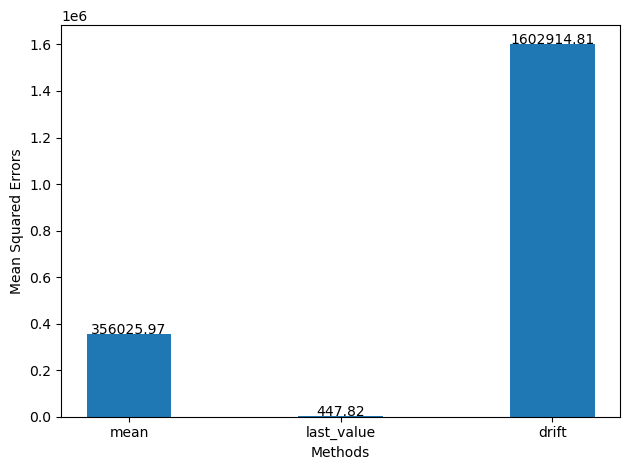

In [41]:
# Plot the results

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('Mean Squared Errors')
# ax.set_ylim(0, 300)

for index, value in enumerate(y):
    plt.text(x=index, y=value+5, s=str(round(value, 2)), ha='center')

plt.tight_layout()


In [43]:
# Forecasting the next steps

df_shift = df[['Close']].shift(1)
df_shift.head()

,Close
0,NaN
1,1270.859985
2,1232.589966
3,1342.180054
4,1346.699951


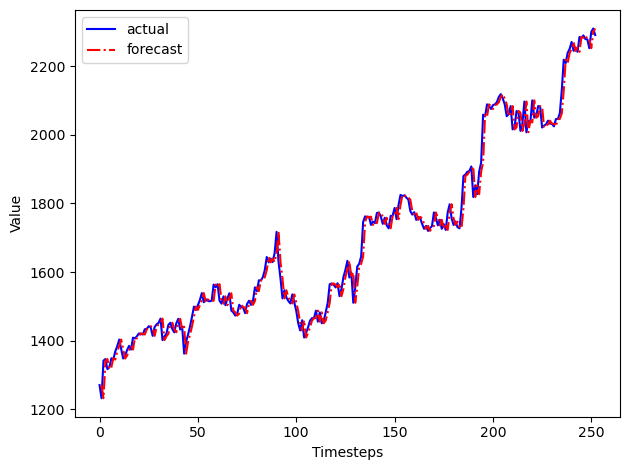

In [44]:
# Plot the forecast over the whole data
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

In [45]:
# Finding the error

mse_test = mean_squared_error(test['Close'],df_shift[-5:])
print(mse_test)

674.8857699967758


#### The last value prediction gave less error compared to the next step forecasting.